# ECG Heartbeat Classification from PTB data

## Introduction

### Import libraries and data

In [0]:
# Baseline imported from https://github.com/CVxTz/ECG_Heartbeat_Classification/blob/master/code/baseline_ptbdb.py?fbclid=IwAR3tPR3HHMsnVo1t90CvaAgTfMFVbo-RDsBJKO1N51Xa_UVXcBLsT7cX_5g
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate, Masking, SimpleRNN, GRU, LSTM, Bidirectional, Add
from keras.utils import plot_model
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [0]:
# Mount google drive to read data thats saved there
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df_1 = pd.read_csv("/content/drive/My Drive/MTEC Master/Semester 2/ml4h_project3/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("/content/drive/My Drive/MTEC Master/Semester 2/ml4h_project3/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

### Illustrate data

Calculate some simple data statistics and plot them as well as possible

We have a total of 14552 data samples with a maximum time length of 52sec, corresponding to 187 points in time.
We have 4046 NORMAL data points, therefore 27.80% of the data.
We have 10506 ABNORMAL data points, therefore 72.20% of the data.



Text(0.5, 1.0, 'Frequency of PTB')

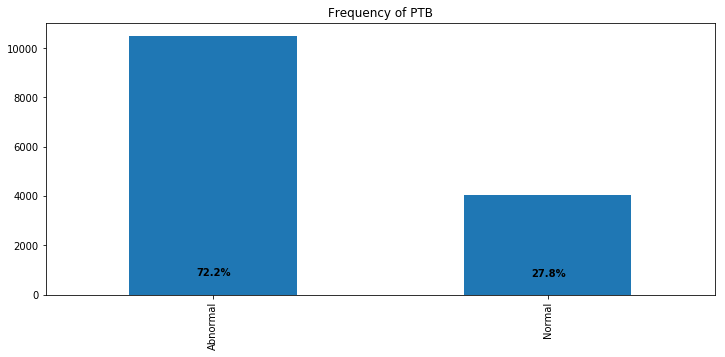

In [0]:
print("We have a total of {} data samples, corresponding to {} points in time.".format(df.shape[0], df.shape[1]-1))
freq_normal = (df_1.shape[0]/df.shape[0])*100
print("We have {} NORMAL data points, therefore {:.2f}% of the data.".format(df_1.shape[0], freq_normal))
freq_abnormal = (df_2.shape[0]/df.shape[0])*100
print("We have {} ABNORMAL data points, therefore {:.2f}% of the data.\n".format(df_2.shape[0], freq_abnormal))
frequencies = [freq_abnormal, freq_normal]

fig, ax = plt.subplots(figsize=(12,5))
df.iloc[:,187].value_counts().plot(ax=ax, kind='bar')
ax.set_xticklabels(['Abnormal', 'Normal'])
for line in range(2):
     ax.text(line-0.05, frequencies[line]+700,s=str(round(frequencies[line],2))+"%", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax.set_title("Frequency of PTB")


Visual plot of how normal heartbeat looks like and how an irregular heartbeat looks like.
(4046, 188)


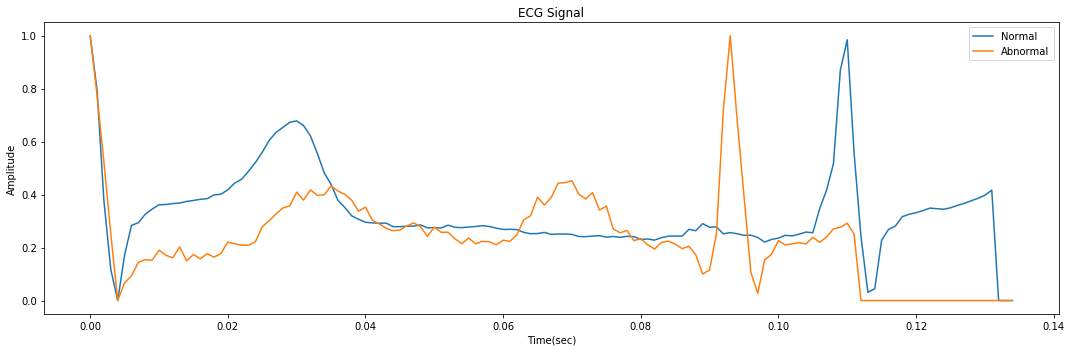

In [78]:
print("Visual plot of how normal heartbeat looks like and how an irregular heartbeat looks like.")
print(df_1.shape)
df_1.iloc[0,:80]
x_length = 135
x=np.arange(187)/1000
plt.figure(figsize=(15,5))
plt.plot(x[:x_length],df_1.iloc[1,:x_length].ravel(),label='Normal')
plt.plot(x[:x_length],df_2.iloc[6,:x_length].ravel(),label='Abnormal')
plt.legend()
plt.xlabel('Time(sec)')
plt.ylabel("Amplitude")
plt.title("ECG Signal")
plt.tight_layout()
plt.show()

### Split data

In [0]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])


Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

## Model Implementations

For computational reasons we decided to only train the models for the PTBDB dataset for 10 epochs. For the MIT dataset and Transfer learning tasks we learned for the full 100 epochs.

If you want to use 100 epochs please change the variable below.

In [0]:
n_epochs = 10

### Baseline model implementation

Code directly obtained from https://github.com/CVxTz/ECG_Heartbeat_Classification/blob/master/code/baseline_ptbdb.py

In [0]:
def get_baseline_model():
    nclass = 1
    inp = Input(shape=(187, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

Add AUROC and AUPRC score to evaluate all models

In [0]:
model_baseline = get_baseline_model()
file_path = "baseline_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model_baseline.fit(X, Y, epochs=n_epochs, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model_baseline.load_weights(file_path)

pred_test = model_baseline.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

print('Baseline model results')
f1 = f1_score(Y_test, pred_test)
print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : %s "% acc)

# calculate Receiver Operating Characteristics AUC
roc_auc = roc_auc_score(Y_test, pred_test)
print("AUROC score : %s "% roc_auc)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, pred_test)
# calculate precision-recall AUC
prc_auc = auc(recall, precision)
print("AUPRC score : %s "% prc_auc)

baseline_results = [f1, acc, roc_auc, prc_auc]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 183, 16)           96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 179, 16)           1296      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 89, 16)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 89, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)    

### Simple RNN implementation

In [0]:
def get_simple_rnn_model(dropout=True):
    nclass = 1
    inp = Input(shape=(187, 1))
    mask_inp = Masking(mask_value=0.)(inp)
    img_1 = SimpleRNN(64)(mask_inp)
    if(dropout):
      img_1 = Dropout(rate=0.2)(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

Test simple RNN model and try once with and without drop out layer

In [0]:
model = get_simple_rnn_model(dropout=False)
file_path = "simple_rnn_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model.fit(X, Y, epochs=n_epochs, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

print('Simple RNN model results')
f1 = f1_score(Y_test, pred_test)
print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : %s "% acc)

# calculate Receiver Operating Characteristics AUC
roc_auc = roc_auc_score(Y_test, pred_test)
print("AUROC score : %s "% roc_auc)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, pred_test)
# calculate precision-recall AUC
prc_auc = auc(recall, precision)
print("AUPRC score : %s "% prc_auc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
masking_1 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                4224      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3_ptbdb (Dense)        (None, 1)                 65        
Total params: 12,609
Trainable params: 12,609
Non-trainable params: 0
_________________________________________________________________
Instru

In [0]:
model = get_simple_rnn_model(dropout=True)
file_path = "simple_rnn_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model.fit(X, Y, epochs=n_epochs, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

print('Simple RNN model results')
f1 = f1_score(Y_test, pred_test)
print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : %s "% acc)

# calculate Receiver Operating Characteristics AUC
roc_auc = roc_auc_score(Y_test, pred_test)
print("AUROC score : %s "% roc_auc)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, pred_test)
# calculate precision-recall AUC
prc_auc = auc(recall, precision)
print("AUPRC score : %s "% prc_auc)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
masking_2 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                4224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
___________________________

Drop out improves model considerably. For all future implementations we will therefore use dropout.

### GRU implementation

> Test different hidden layer size



In [0]:
def get_gru_model(n_hidden=64):
    nclass = 1
    inp = Input(shape=(187, 1))
    mask_inp = Masking(mask_value=0.)(inp)
    img_1 = GRU(n_hidden)(mask_inp)
    img_1 = Dropout(rate=0.2)(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [0]:
model = get_gru_model(n_hidden=64)
file_path = "gru_64_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model.fit(X, Y, epochs=n_epochs, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

print('GRU with 64 hidden layers model results')
f1 = f1_score(Y_test, pred_test)
print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : %s "% acc)

# calculate Receiver Operating Characteristics AUC
roc_auc = roc_auc_score(Y_test, pred_test)
print("AUROC score : %s "% roc_auc)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, pred_test)
# calculate precision-recall AUC
prc_auc = auc(recall, precision)
print("AUPRC score : %s "% prc_auc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
masking_3 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                12672     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3_ptbdb (Dense)        (None, 1)                 65        
Total para

In [0]:
model = get_gru_model(n_hidden=128)
file_path = "gru_128_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model.fit(X, Y, epochs=n_epochs, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

print('GRU with 128 hidden layers model results')
f1 = f1_score(Y_test, pred_test)
print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : %s "% acc)

# calculate Receiver Operating Characteristics AUC
roc_auc = roc_auc_score(Y_test, pred_test)
print("AUROC score : %s "% roc_auc)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, pred_test)
# calculate precision-recall AUC
prc_auc = auc(recall, precision)
print("AUPRC score : %s "% prc_auc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
masking_4 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               49920     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3_ptbdb (Dense)        (None, 1)                 65        
Total para

### LSTM implementation

In [0]:
def get_lstm_model():
    nclass = 1
    inp = Input(shape=(187, 1))
    mask_inp = Masking(mask_value=0.)(inp)
    img_1 = LSTM(64)(mask_inp)
    img_1 = Dropout(rate=0.2)(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [0]:
model = get_lstm_model()
file_path = "lstm_64_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model.fit(X, Y, epochs=n_epochs, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

print('LSTM with 64 hidden layers model results')
f1 = f1_score(Y_test, pred_test)
print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : %s "% acc)

# calculate Receiver Operating Characteristics AUC
roc_auc = roc_auc_score(Y_test, pred_test)
print("AUROC score : %s "% roc_auc)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, pred_test)
# calculate precision-recall AUC
prc_auc = auc(recall, precision)
print("AUPRC score : %s "% prc_auc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
masking_5 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3_ptbdb (Dense)        (None, 1)                 65        
Total para

Out of simple RNN, GRU and LSTM, GRU performs best and LSTM is closely behind while simple RNN is worse.
We will therefore use GRU models in the future except if specified otherwise.

### Bidirectional GRU implementation

> Test Different merge methods for bidirectional model




In [0]:
def get_bidirectional_gru_model(mode='sum', n_hidden=64, n_stacked_layers=1):
    nclass = 1
    inp = Input(shape=(187, 1))
    gru_inp = Masking(mask_value=0.)(inp)
    for n in range(n_stacked_layers):
      return_seq = (n<n_stacked_layers-1)
      gru_inp = Bidirectional(GRU(n_hidden, return_sequences=return_seq), merge_mode=mode)(gru_inp)
      gru_inp = Dropout(rate=0.2)(gru_inp)
    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(gru_inp)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [0]:
for mode in ['sum', 'mul', 'concat', 'ave']:
  print('Using mode: ', mode)
  model = get_bidirectional_gru_model(mode)
  file_path = "bidirectional_gru_{}_ptbdb.h5".format(mode)
  checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
  redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
  callbacks_list = [checkpoint, early, redonplat]  # early

  model.fit(X, Y, epochs=n_epochs, verbose=2, callbacks=callbacks_list, validation_split=0.1)
  model.load_weights(file_path)

  pred_test = model.predict(X_test)
  pred_test = (pred_test>0.5).astype(np.int8)
  
  print('Bidirectional({}) GRU with 64 hidden layers model results'.format(mode))
  f1 = f1_score(Y_test, pred_test)
  print("Test f1 score : %s "% f1)

  acc = accuracy_score(Y_test, pred_test)
  print("Test accuracy score : %s "% acc)
  
  # calculate Receiver Operating Characteristics AUC
  roc_auc = roc_auc_score(Y_test, pred_test)
  print("AUROC score : %s "% roc_auc)

  # calculate precision-recall curve
  precision, recall, thresholds = precision_recall_curve(Y_test, pred_test)
  # calculate precision-recall AUC
  prc_auc = auc(recall, precision)
  print("AUPRC score : %s "% prc_auc)

Using mode:  sum
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
masking_6 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                25344     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3_ptbdb (Dense)        (None, 1)                 65  

Testing Bidirectional GRU model with different merge methods. 
- Concatenating and sum work well
- Mul works well but generally not as good

Use sum/concat in the future

### Stacking Bidirectional models

> Test Drop out in every layer or only after first or last layer



In [64]:
# Drop out after last layer
def get_bidirectional_gru_model(mode='sum', n_hidden=64, n_stacked_layers=1):
    nclass = 1
    inp = Input(shape=(187, 1))
    gru_inp = Masking(mask_value=0.)(inp)
    for n in range(n_stacked_layers):
      return_seq = (n<n_stacked_layers-1)
      gru_inp = Bidirectional(GRU(n_hidden, return_sequences=return_seq), merge_mode=mode)(gru_inp)
    gru_inp = Dropout(rate=0.2)(gru_inp)
    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(gru_inp)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model
  
print('Using 2 stacked layers of GRU cells: ')
model = get_bidirectional_gru_model('sum', 64, 2)
file_path = "bidirectional_gru_{}layers_{}hidden_dropoutlast_ptbdb.h5".format(2, 64)
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model.fit(X, Y, epochs=n_epochs, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

print('{} layer stack of bidirectional GRU with dropout after last RNN layer model results'.format(2))
f1 = f1_score(Y_test, pred_test)
print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : %s "% acc)

# calculate Receiver Operating Characteristics AUC
roc_auc = roc_auc_score(Y_test, pred_test)
print("AUROC score : %s "% roc_auc)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, pred_test)
# calculate precision-recall AUC
prc_auc = auc(recall, precision)
print("AUPRC score : %s "% prc_auc)

Using 2 stacked layers of GRU cells: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
masking_9 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 187, 64)           25344     
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 64)                49536     
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64

In [65]:
# Drop out only after first layer
def get_bidirectional_gru_model(mode='sum', n_hidden=64, n_stacked_layers=1):
    nclass = 1
    inp = Input(shape=(187, 1))
    gru_inp = Masking(mask_value=0.)(inp)
    for n in range(n_stacked_layers):
      return_seq = (n<n_stacked_layers-1)
      gru_inp = Bidirectional(GRU(n_hidden, return_sequences=return_seq), merge_mode=mode)(gru_inp)
      if(n==0):
        gru_inp = Dropout(rate=0.2)(gru_inp)
    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(gru_inp)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model
  
print('Using 2 stacked layers of GRU cells: ')
model = get_bidirectional_gru_model('sum', 64, 2)
file_path = "bidirectional_gru_{}layers_{}hidden_dropoutfirst_ptbdb.h5".format(2, 64)
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model.fit(X, Y, epochs=n_epochs, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

print('{} layer stack of bidirectional GRU with dropout after first RNN layer model results'.format(2))
f1 = f1_score(Y_test, pred_test)
print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : %s "% acc)

# calculate Receiver Operating Characteristics AUC
roc_auc = roc_auc_score(Y_test, pred_test)
print("AUROC score : %s "% roc_auc)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, pred_test)
# calculate precision-recall AUC
prc_auc = auc(recall, precision)
print("AUPRC score : %s "% prc_auc)

Using 2 stacked layers of GRU cells: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 187, 1)            0         
_________________________________________________________________
masking_10 (Masking)         (None, 187, 1)            0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 187, 64)           25344     
_________________________________________________________________
dropout_15 (Dropout)         (None, 187, 64)           0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 64)                49536     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64

In [0]:
hidden=64
for stack_layers in [2,3]:
  print('Using {} stacked layers of GRU cells: '.format(stack_layers))
  model = get_bidirectional_gru_model('sum', hidden, stack_layers)
  file_path = "bidirectional_gru_{}layers_{}hidden_ptbdb.h5".format(stack_layers, hidden)
  checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
  redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
  callbacks_list = [checkpoint, early, redonplat]  # early

  model.fit(X, Y, epochs=n_epochs, verbose=2, callbacks=callbacks_list, validation_split=0.1)
  model.load_weights(file_path)

  pred_test = model.predict(X_test)
  pred_test = (pred_test>0.5).astype(np.int8)

  print('{} layer stack of bidirectional GRU model results'.format(stack_layers))
  f1 = f1_score(Y_test, pred_test)
  print("Test f1 score : %s "% f1)

  acc = accuracy_score(Y_test, pred_test)
  print("Test accuracy score : %s "% acc)
  
  # calculate Receiver Operating Characteristics AUC
  roc_auc = roc_auc_score(Y_test, pred_test)
  print("AUROC score : %s "% roc_auc)

  # calculate precision-recall curve
  precision, recall, thresholds = precision_recall_curve(Y_test, pred_test)
  # calculate precision-recall AUC
  prc_auc = auc(recall, precision)
  print("AUPRC score : %s "% prc_auc)

Using 2 stacked layers of GRU cells: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        (None, 187, 1)            0         
_________________________________________________________________
masking_35 (Masking)         (None, 187, 1)            0         
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 187, 128)          25344     
_________________________________________________________________
dropout_57 (Dropout)         (None, 187, 128)          0         
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 128)               74112     
_________________________________________________________________
dropout_58 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64

The bigger the stack the better the performance. With a stack of three we already get a 93% accuracy and 97.6% AUPRC. However with a bigger stack the more time it takes to learn each model and computation becomes considerably more expensive:

## Ensemble


### Models to use for ensemble

Gather all results in dictionary.

In [0]:
result_dict = dict()
# Add baseline results
result_dict['CNN baseline'] = baseline_results

#### 1. Bidirectional GRU; hidden size=128, stack layers=1, merge method=sum


> Learn a wide model with big hidden size of GRU



In [0]:
model_big_hidden = get_bidirectional_gru_model(mode='sum', n_hidden=128, n_stacked_layers=1)

file_path = "bi_gru_128_1stacklayer_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model_big_hidden.fit(X, Y, epochs=n_epochs, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model_big_hidden.load_weights(file_path)

pred_test = model_big_hidden.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

print('1 Layer of Bidirectional GRU with 128 hidden layers model results')
f1 = f1_score(Y_test, pred_test)
print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : %s "% acc)

# calculate Receiver Operating Characteristics AUC
roc_auc = roc_auc_score(Y_test, pred_test)
print("AUROC score : %s "% roc_auc)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, pred_test)
# calculate precision-recall AUC
prc_auc = auc(recall, precision)
print("AUPRC score : %s "% prc_auc)

result_dict['Bid. GRU Hidden State Size=128'] = [f1, acc, roc_auc, prc_auc]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
masking_4 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               99840     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3_ptbdb (Dense)        (None, 1)                 65        
Total para

#### 2. Bidirectional GRU; hidden size=64, stack layers=2, merge method=sum

> Learn deeper model which isn't too expensive to learn



In [66]:
model_2layerstack = get_bidirectional_gru_model(mode='sum', n_hidden=64, n_stacked_layers=2)

file_path = "bi_gru_64_2stacklayer_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model_2layerstack.fit(X, Y, epochs=n_epochs, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model_2layerstack.load_weights(file_path)

pred_test = model_2layerstack.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

print('2 Layer of Bidirectional GRU with 64 hidden layers model results')
f1 = f1_score(Y_test, pred_test)
print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : %s "% acc)

# calculate Receiver Operating Characteristics AUC
roc_auc = roc_auc_score(Y_test, pred_test)
print("AUROC score : %s "% roc_auc)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, pred_test)
# calculate precision-recall AUC
prc_auc = auc(recall, precision)
print("AUPRC score : %s "% prc_auc)

result_dict['2 Stacked Bid. GRU Hidden State Size=64'] = [f1, acc, roc_auc, prc_auc]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 187, 1)            0         
_________________________________________________________________
masking_11 (Masking)         (None, 187, 1)            0         
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 187, 64)           25344     
_________________________________________________________________
dropout_16 (Dropout)         (None, 187, 64)           0         
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 64)                49536     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
__________

#### 3. Bidirectional GRU; hidden size=64, stack layers=3, merge method=sum

> Learn deep model with 3 layers. Is a lot more expensive to learn so mostly not used in ensemble models



In [0]:
model_3layerstack = get_bidirectional_gru_model(mode='sum', n_hidden=64, n_stacked_layers=3)

file_path = "bi_gru_64_3stacklayer_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model_3layerstack.fit(X, Y, epochs=n_epochs, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model_3layerstack.load_weights(file_path)

pred_test = model_3layerstack.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

print('3 Layer of Bidirectional GRU with 64 hidden layers model results')
f1 = f1_score(Y_test, pred_test)
print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : %s "% acc)

# calculate Receiver Operating Characteristics AUC
roc_auc = roc_auc_score(Y_test, pred_test)
print("AUROC score : %s "% roc_auc)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, pred_test)
# calculate precision-recall AUC
prc_auc = auc(recall, precision)
print("AUPRC score : %s "% prc_auc)

result_dict['3 Stacked Bid. GRU Hidden State Size=64'] = [f1, acc, roc_auc, prc_auc]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
masking_7 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 187, 64)           25344     
_________________________________________________________________
dropout_10 (Dropout)         (None, 187, 64)           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 187, 64)           49536     
_________________________________________________________________
dropout_11 (Dropout)         (None, 187, 64)           0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 64)                49536     
__________

#### 4. Bidirectional LSTM; hidden size=64, stack layers=1, concat=sum, mode=sum

> Learn Bidirectional LSTM model that might learn better long term dependecies in comparison to other ensemble models



In [0]:
def get_bidirectional_lstm_model(mode='sum', n_hidden=64, n_stacked_layers=1):
    nclass = 1
    inp = Input(shape=(187, 1))
    rnn_inp = Masking(mask_value=0.)(inp)
    for n in range(n_stacked_layers):
      return_seq = (n<n_stacked_layers-1)
      rnn_inp = Bidirectional(LSTM(n_hidden, return_sequences=return_seq), merge_mode=mode)(rnn_inp)
      rnn_inp = Dropout(rate=0.2)(rnn_inp)
    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(rnn_inp)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.sigmoid, name="dense_3_ptbdb")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [0]:
model_lstm = get_bidirectional_lstm_model(mode='sum', n_hidden=64, n_stacked_layers=1)

file_path = "biadd_lstm_64hidden_1stacklayer_ptbdb.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model_lstm.fit(X, Y, epochs=n_epochs, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model_lstm.load_weights(file_path)

pred_test = model_lstm.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

print('1 Layer of Bidirectional(add) LSTM with 64 hidden layers model results')
f1 = f1_score(Y_test, pred_test)
print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : %s "% acc)

# calculate Receiver Operating Characteristics AUC
roc_auc = roc_auc_score(Y_test, pred_test)
print("AUROC score : %s "% roc_auc)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, pred_test)
# calculate precision-recall AUC
prc_auc = auc(recall, precision)
print("AUPRC score : %s "% prc_auc)

result_dict['Bid. LSTM Hidden state size=64'] = [f1, acc, roc_auc, prc_auc]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 187, 1)            0         
_________________________________________________________________
masking_3 (Masking)          (None, 187, 1)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                33792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3_ptbdb (Dense)        (None, 1)                 65        
Total para

### Ensemble by averaging predictions


>Weights chosen by performance (0.3 2layer, 0.3 3layer, 0.2 big hidden, 0.2 lstm)



In [70]:
pred_test_model2layerstack = model_2layerstack.predict(X_test)
pred_test_model3layerstack = model_3layerstack.predict(X_test)
pred_test_model_bighidden = model_big_hidden.predict(X_test)
pred_test_model_lstm = model_lstm.predict(X_test)

pred_test_ensemble = np.array([pred_test_model2layerstack, pred_test_model3layerstack, pred_test_model_bighidden, pred_test_model_lstm])
pred_test = np.average(pred_test_ensemble, weights=[0.3,0.3,0.2, 0.2], axis=0)
pred_test = (pred_test>0.5).astype(np.int8)

print('Ensemble Model by averaging')
f1 = f1_score(Y_test, pred_test)
print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : %s "% acc)

# calculate Receiver Operating Characteristics AUC
roc_auc = roc_auc_score(Y_test, pred_test)
print("AUROC score : %s "% roc_auc)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, pred_test)
# calculate precision-recall AUC
prc_auc = auc(recall, precision)
print("AUPRC score : %s "% prc_auc)

result_dict['Ensemble by Averaging models'] = [f1, acc, roc_auc, prc_auc]

Ensemble Model by averaging
Test f1 score : 0.9700259617654 
Test accuracy score : 0.9563723806252147 
AUROC score : 0.9393764135398743 
AUPRC score : 0.9781576354749486 


### Ensemble model with logistic regression

> Should at least improve or equal to averaging ensemble but doens't learn und doesn't learn throughout epochs.



In [0]:
#Validation set
X_val = X[int(len(X)*0.9):]
Y_val = Y[int(len(Y)*0.9):]
pred_val = []
pred_test = []

ensemble_models = [model_big_hidden, model_2layerstack, model_3layerstack, model_lstm]
for i in range(len(ensemble_models)):
  pred_val.append(ensemble_models[i].predict(X_val))
  pred_test.append(ensemble_models[i].predict(X_test))
pred_val_ensemble = np.concatenate (tuple(pred_val), axis=1)
pred_test_ensemble = np.concatenate (tuple(pred_test), axis=1)

In [72]:
ensemble_lr = LogisticRegression(C=100)
ensemble_lr.fit(pred_val_ensemble, Y_val)

pred_test = ensemble_lr.predict(pred_test_ensemble)
pred_test = (pred_test>0.5).astype(np.int8)

print('Ensemble Model with logistic regression')
f1 = f1_score(Y_test, pred_test)
print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)
print("Test accuracy score : %s "% acc)

# calculate Receiver Operating Characteristics AUC
roc_auc = roc_auc_score(Y_test, pred_test)
print("AUROC score : %s "% roc_auc)

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, pred_test)
# calculate precision-recall AUC
prc_auc = auc(recall, precision)
print("AUPRC score : %s "% prc_auc)

result_dict['Ensemble by fitting a Logistic Regression Model'] = [f1, acc, roc_auc, prc_auc]

Ensemble Model with logistic regression
Test f1 score : 0.973178257773558 
Test accuracy score : 0.9611817244933013 
AUROC score : 0.9499299625173034 
AUPRC score : 0.9821143375463377 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Results

In [88]:
Results1 = pd.DataFrame.from_dict(result_dict, orient='index',columns=['Test F1 score', 'Test Accuracy', 'Test AUROC', 'Test AUPRC'])
Results1

,Test F1 score,Test Accuracy,Test AUROC,Test AUPRC
Ensemble by Averaging models,0.970026,0.956372,0.939376,0.978158
Ensemble by fitting a Logistic Regression Model,0.973178,0.961182,0.949930,0.982114
Bid. GRU Hidden State Size=128,0.965567,0.950532,0.942556,0.979850
2 Stacked Bid. GRU Hidden State Size=64,0.961728,0.944005,0.919788,0.971164
3 Stacked Bid. GRU Hidden State Size=64,0.919347,0.884576,0.863430,0.951543
Bid. LSTM Hidden state size=64,0.907308,0.863621,0.815084,0.934927
